In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy

import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin


from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from imblearn.pipeline import Pipeline
from transformers import RobertaModel,RobertaTokenizer
import tensorflow as tf
import keras_nlp
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import RobertaTokenizer, RobertaModel

from sentence_transformers import SentenceTransformer, InputExample, losses


In [2]:
!pip install language_tool_python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.7 MB/s eta 0:00:00


In [3]:
import language_tool_python

## Dataset Load + EDA

In [2]:
df = pd.read_csv("/kaggle/input/job-vacancy-train/train.csv")

In [3]:
df_test = pd.read_csv('/kaggle/input/job-vacancy-test/test.csv')

In [4]:
df

,resume_text,job_description_text,label
0,SummaryHighly motivated Sales Associate with e...,Net2Source Inc. is an award-winning total work...,No Fit
1,Professional SummaryCurrently working with Cat...,At Salas OBrien we tell our clients that were ...,No Fit
2,SummaryI started my construction career in Jun...,Schweitzer Engineering Laboratories (SEL) Infr...,No Fit
3,SummaryCertified Electrical Foremanwith thirte...,"Mizick Miller & Company, Inc. is looking for a...",No Fit
4,SummaryWith extensive experience in business/r...,Life at Capgemini\nCapgemini supports all aspe...,No Fit
...,...,...,...
6236,SummaryResults-driven Data Entry Clerk with ex...,"Hi,\nHope you are doing great today. Please fi...",Good Fit
6237,Professional SummaryWith the attitude of learn...,Job Title: DHT - Front End Software Engineer W...,Good Fit
6238,Summary• \nOver\nThree years of extensi...,LHH Recruitment Solutions is looking for a Sof...,Good Fit
6239,ProfileAbility to prioritize and multi-task in...,Our client is a growing Medical Device company...,Good Fit


In [6]:
class_labels = df["label"].unique()

In [4]:
df['label'] = df['label'].replace('Potential Fit', 'Good Fit')

In [5]:
df_test['label'] = df_test['label'].replace('Potential Fit', 'Good Fit')

In [28]:
class_labels

array(['No Fit', 'Good Fit'], dtype=object)

In [7]:
df.shape

(6241, 3)

In [36]:
df.columns

Index(['resume_text', 'job_description_text', 'label'], dtype='object')

In [10]:
print(f'Number of duplicate entries: {df_test.duplicated().sum()}')

Number of duplicate entries: 0


In [7]:
df.drop_duplicates(inplace=True)

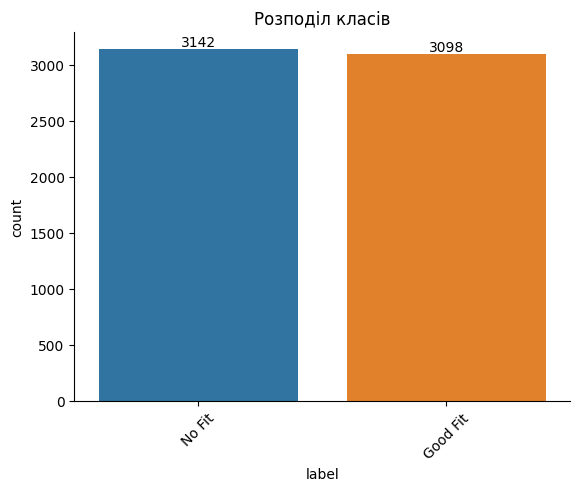

In [11]:
ax = sns.countplot(data=df, x='label')
ax.set_title('Розподіл класів')
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

sns.despine()
plt.show()

## Data Preprocessing

In [9]:
class TransformerPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words_en = set(stopwords.words('english'))
        self.nlp = spacy.load("en_core_web_sm")
        #self.tool = language_tool_python.LanguageTool('en-US')

    # def correct_grammar(self, text):
    #     try:
    #         matches = self.tool.check(text)
    #         return language_tool_python.utils.correct(text, matches)
    #     except Exception:
    #         return text

    def remove_urls(self, text):
        return re.sub(r'http[s]?://\S+|www\.\S+', '<url>', text)


    def clean_text(self, text):
        text = text.lower() 
        text = self.remove_urls(text)
        text = re.sub(r"<[^>]+>", " ", text)
        text = re.sub(r'\bsummary(?=\S)', 'summary ', text)
        text = re.sub(r"\s+", " ", text).strip()
        text = re.sub(r"[^\w\s\.,'!?]", '', text)
        return text

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.clean_text(text) for text in X]

In [10]:
preprocessor = Pipeline([
    ('preprocessor', TransformerPreprocessor())
])

In [8]:
df['label_int'] = df['label'].map({'Good Fit': 1, 'No Fit': 0})
df_test['label_int'] = df_test['label'].map({'Good Fit': 1, 'No Fit': 0})

In [18]:
df['label']

0         No Fit
1         No Fit
2         No Fit
3         No Fit
4         No Fit
          ...   
6236    Good Fit
6237    Good Fit
6238    Good Fit
6239    Good Fit
6240    Good Fit
Name: label, Length: 6240, dtype: object

In [9]:
df['label_int'] 

0       0
1       0
2       0
3       0
4       0
       ..
6236    1
6237    1
6238    1
6239    1
6240    1
Name: label_int, Length: 6240, dtype: int64

In [32]:
df['resume_text_clean'] = preprocessor.fit_transform(df['resume_text'])
df['job_description_text_clean'] = preprocessor.fit_transform(df['job_description_text'])

In [33]:
df_test['resume_text_clean'] = preprocessor.transform(df_test['resume_text'])
df_test['job_description_text_clean'] = preprocessor.transform(df_test['job_description_text'])

In [32]:
df['job_description_text_clean'][1]

'at salas obrien we tell our clients that were engineered for impact. this passion for making a difference applies just as much to our team as it does to our projects. thats why were committed to living our values every day inspiring, achieving, and connecting as shared owners of our success with a focus on a sustainable future. building for the longterm means that all of our team members can expect to work on amazing projects with a peoplefirst approach to problem solving. it also means that each member of our team has truly limitless potential to build a unique, meaningful, and highimpact careerand theyll receive great total rewards along the way. about us founded in 1975, salas obrien is an employeeowned engineering and professional services firm focused on achieving impact for our clients, our team, and the world. we know that tomorrows requirements are todays opportunities, and we are here to design lasting solutions for pressing challenges. we work across a variety of industries 

## Pre model preprocessing

In [10]:
class ResumeJobDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256):  
        self.df = df
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self): 
        return len(self.df)

    def __getitem__(self, index): 
        resume = self.df.iloc[index]['resume_text']
        job = self.df.iloc[index]['job_description_text']
        label = self.df.iloc[index]['label_int']

        resume_enc = self.tokenizer(
            resume,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        job_enc = self.tokenizer(
            job,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            'resume_input_ids': resume_enc['input_ids'].squeeze(0),
            'resume_attention_mask': resume_enc['attention_mask'].squeeze(0),
            'job_input_ids': job_enc['input_ids'].squeeze(0),
            'job_attention_mask': job_enc['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }


In [11]:
class TripletResumeJobDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length

        self.good_pairs = df[df['label_int'] == 0].reset_index(drop=True)
        self.bad_pairs = df[df['label_int'] == 1].reset_index(drop=True)

    def __len__(self):
        return len(self.good_pairs)

    def __getitem__(self, idx):
        anchor_resume = self.good_pairs.iloc[idx]['resume_text']
        positive_job = self.good_pairs.iloc[idx]['job_description_text']
        negative_job = self.bad_pairs.sample(1).iloc[0]['job_description_text']

        anchor_enc = self.tokenizer(anchor_resume, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        pos_enc = self.tokenizer(positive_job, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        neg_enc = self.tokenizer(negative_job, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")

        return {
            'anchor_input_ids': anchor_enc['input_ids'].squeeze(0),
            'anchor_attention_mask': anchor_enc['attention_mask'].squeeze(0),
            'pos_input_ids': pos_enc['input_ids'].squeeze(0),
            'pos_attention_mask': pos_enc['attention_mask'].squeeze(0),
            'neg_input_ids': neg_enc['input_ids'].squeeze(0),
            'neg_attention_mask': neg_enc['attention_mask'].squeeze(0)
        }


MoE - Switch Transformer

## Model

In [12]:
class SiameseRoBERTa(nn.Module):
    def __init__(self, freeze_ratio=0.8):
        super(SiameseRoBERTa, self).__init__()
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(768 * 2, 1)
        self.freeze_roberta_layers(freeze_ratio)

    def freeze_roberta_layers(self, freeze_ratio):
        total_layers = len(self.roberta.encoder.layer)
        freeze_layers = int(total_layers * freeze_ratio)

        for i in range(freeze_layers):
            for param in self.roberta.encoder.layer[i].parameters():
                param.requires_grad = False

    def encode(self, input_ids, attention_mask):
        output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled = output.pooler_output 
        return self.dropout(pooled)

    def forward(self, resume_ids, resume_mask, job_ids, job_mask):
        resume_vec = self.encode(resume_ids, resume_mask)
        job_vec = self.encode(job_ids, job_mask)
        return resume_vec, job_vec

    # def forward(
    #     self,
    #     anchor_input_ids, anchor_attention_mask,
    #     pos_input_ids, pos_attention_mask,
    #     neg_input_ids, neg_attention_mask
    # ):
    #     anchor_vec = self.encode(anchor_input_ids, anchor_attention_mask)
    #     pos_vec = self.encode(pos_input_ids, pos_attention_mask)
    #     neg_vec = self.encode(neg_input_ids, neg_attention_mask)
    #     return anchor_vec, pos_vec, neg_vec

## Model Training

ContrastiveLoss, TripletLoss, або CosineEmbeddingLoss

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [14]:
train_dataset = ResumeJobDataset(df, tokenizer)
val_dataset = ResumeJobDataset(df_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)


In [36]:
train_dataset = TripletResumeJobDataset(df, tokenizer)
val_dataset = TripletResumeJobDataset(df_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [15]:
model = SiameseRoBERTa(freeze_ratio=0.8).to(device)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)
criterion = nn.CosineEmbeddingLoss(margin=0.5)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
import torch.nn.functional as F

def compute_cosine_similarity(vec1, vec2):
    return F.cosine_similarity(vec1, vec2)

In [37]:

train_losses = []
val_losses = []

model = SiameseRoBERTa(freeze_ratio=0.8).to(device)
criterion = nn.TripletMarginLoss(margin=1.0, p=2)  # Cosine також можна, але тут p=2 — евклідова
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)

EPOCHS = 5
progress_bar = tqdm(range(EPOCHS * len(train_loader)))

model.train()
for epoch in range(EPOCHS):
    total_train_loss = 0.0

    for batch in train_loader:
        model.train()
        optimizer.zero_grad()

        anchor_vecs, pos_vecs, neg_vecs = model(
            batch['anchor_input_ids'].to(device),
            batch['anchor_attention_mask'].to(device),
            batch['pos_input_ids'].to(device),
            batch['pos_attention_mask'].to(device),
            batch['neg_input_ids'].to(device),
            batch['neg_attention_mask'].to(device),
        )

        loss = criterion(anchor_vecs, pos_vecs, neg_vecs)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        progress_bar.update(1)

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation (optional)
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            anchor_vecs, pos_vecs, neg_vecs = model(
                batch['anchor_input_ids'].to(device),
                batch['anchor_attention_mask'].to(device),
                batch['pos_input_ids'].to(device),
                batch['pos_attention_mask'].to(device),
                batch['neg_input_ids'].to(device),
                batch['neg_attention_mask'].to(device),
            )

            val_loss = criterion(anchor_vecs, pos_vecs, neg_vecs)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"\nEpoch {epoch + 1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/485 [00:00<?, ?it/s]


Epoch 1/5 | Train Loss: 1.0021 | Val Loss: 1.1793

Epoch 2/5 | Train Loss: 0.5909 | Val Loss: 0.8091

Epoch 3/5 | Train Loss: 0.4590 | Val Loss: 1.1501

Epoch 4/5 | Train Loss: 0.3802 | Val Loss: 1.9712

Epoch 5/5 | Train Loss: 0.4568 | Val Loss: 2.1100


In [36]:
def compute_accuracy(preds, targets, threshold=0.5):
    """
    Обчислює точність на основі порогового значення для подібності.
    :param preds: передбачені значення подібності (косинусна подібність)
    :param targets: реальні мітки (1 для позитивних, 0 для негативних)
    :param threshold: порогове значення для прийняття рішення
    :return: точність
    """
    # Перетворюємо передбачення в 0 або 1 в залежності від порогу
    predicted_labels = (preds >= threshold).astype(int)
    correct_preds = (predicted_labels == targets).sum()
    accuracy = correct_preds / len(targets)
    return accuracy

In [18]:
model = SiameseRoBERTa(freeze_ratio=0.8).to(device)
criterion = nn.CosineEmbeddingLoss(margin=0.3)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4)
EPOCHS = 15
progress_bar = tqdm(range(EPOCHS * len(train_loader)))

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/2925 [00:00<?, ?it/s]

In [23]:
def compute_cosine_similarity(a, b):
    return F.cosine_similarity(a, b)


def compute_accuracy(similarities, labels, threshold=0.5):
    preds = (similarities > threshold).float()
    return (preds == labels).float().mean().item()

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Ініціалізація
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_val_acc = 0.0
#checkpoint_path = "cosemb_base.pth"

for epoch in range(EPOCHS):
    model.train()
    epoch_train_losses = []
    epoch_train_accuracies = []

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()

        resume_vecs, job_vecs = model(
            batch['resume_input_ids'].to(device),
            batch['resume_attention_mask'].to(device),
            batch['job_input_ids'].to(device),
            batch['job_attention_mask'].to(device)
        )
        
        
        similarities = compute_cosine_similarity(resume_vecs, job_vecs)
        labels = batch['label'].to(device)

        # Перетворення міток для CosineEmbeddingLoss
        targets = labels * 2 - 1  # 0 -> -1, 1 -> 1

        loss = criterion(resume_vecs, job_vecs, targets)
        loss.backward()
        optimizer.step()

        epoch_train_losses.append(loss.item())
        acc = compute_accuracy(similarities, labels)
        epoch_train_accuracies.append(acc)

    avg_train_loss = np.mean(epoch_train_losses)
    avg_train_acc = np.mean(epoch_train_accuracies)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Accuracy: {avg_train_acc:.4f}")

    # Validation
    model.eval()
    epoch_val_losses = []
    epoch_val_accuracies = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validating Epoch {epoch+1}"):
            resume_vecs, job_vecs = model(
                batch['resume_input_ids'].to(device),
                batch['resume_attention_mask'].to(device),
                batch['job_input_ids'].to(device),
                batch['job_attention_mask'].to(device)
            )
            
            similarities = compute_cosine_similarity(resume_vecs, job_vecs)
            labels = batch['label'].to(device)

            targets = labels * 2 - 1  # Знову перетворення
            val_loss = criterion(resume_vecs, job_vecs, targets)
            epoch_val_losses.append(val_loss.item())

            acc = compute_accuracy(similarities, labels)
            epoch_val_accuracies.append(acc)

    avg_val_loss = np.mean(epoch_val_losses)
    avg_val_acc = np.mean(epoch_val_accuracies)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(f"Epoch {epoch+1} | Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {avg_val_acc:.4f}")


    # if avg_val_acc > best_val_acc:
    #     best_val_acc = avg_val_acc
    #     torch.save(model.state_dict(), checkpoint_path)
    #     print(f"Saved best model at Epoch {epoch+1} with Validation Accuracy: {best_val_acc:.4f}")


Training Epoch 1:   0%|          | 0/195 [00:00<?, ?it/s]

In [ ]:


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

train_similarities = []
val_similarities = []


for epoch in range(EPOCHS):
    model.train()
    total_train_loss = 0.0
    total_train_accuracy = 0.0
    train_preds = []
    train_labels = []

    epoch_train_accuracies = []

    # Train loop
    for batch in train_loader:
        optimizer.zero_grad()

        resume_vecs, job_vecs = model(
            batch['resume_input_ids'].to(device),
            batch['resume_attention_mask'].to(device),
            batch['job_input_ids'].to(device),
            batch['job_attention_mask'].to(device)
        )

        targets = (batch['label'] * 2 - 1).to(device)
        loss = criterion(resume_vecs, job_vecs, targets.float())
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        cosine_sim = compute_cosine_similarity(resume_vecs, job_vecs)
        accuracy = compute_accuracy(cosine_sim.detach().cpu().numpy(), batch['label'].numpy())
        epoch_train_accuracies.append(accuracy)

        progress_bar.update(1)

    # Обчислення середніх значень для поточної епохи
    avg_train_loss = total_train_loss / len(train_loader)
    avg_train_accuracy = np.mean(epoch_train_accuracies)
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    # Validation loop
    model.eval()
    total_val_loss = 0.0
    total_val_accuracy = 0.0
    val_preds = []
    val_labels = []

    epoch_val_accuracies = []

    with torch.no_grad():
        for batch in val_loader:
            resume_vecs, job_vecs = model(
                batch['resume_input_ids'].to(device),
                batch['resume_attention_mask'].to(device),
                batch['job_input_ids'].to(device),
                batch['job_attention_mask'].to(device)
            )
            targets = (batch['label'] * 2 - 1).to(device)
            loss = criterion(resume_vecs, job_vecs, targets.float())
            total_val_loss += loss.item()

            cosine_sim = compute_cosine_similarity(resume_vecs, job_vecs)
            accuracy = compute_accuracy(cosine_sim.detach().cpu().numpy(), batch['label'].numpy())
            epoch_val_accuracies.append(accuracy)

            progress_bar.update(1)

    avg_val_loss = total_val_loss / len(val_loader)
    avg_val_accuracy = np.mean(epoch_val_accuracies)
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    # Виведення результатів на епоху
    print(f"\nEpoch {epoch + 1}/{EPOCHS} | "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train Accuracy: {avg_train_accuracy:.4f} | Val Accuracy: {avg_val_accuracy:.4f}")

## Evaluation

In [90]:
torch.save(model.state_dict(), 'siamese_roberta_cosembloss.pth')

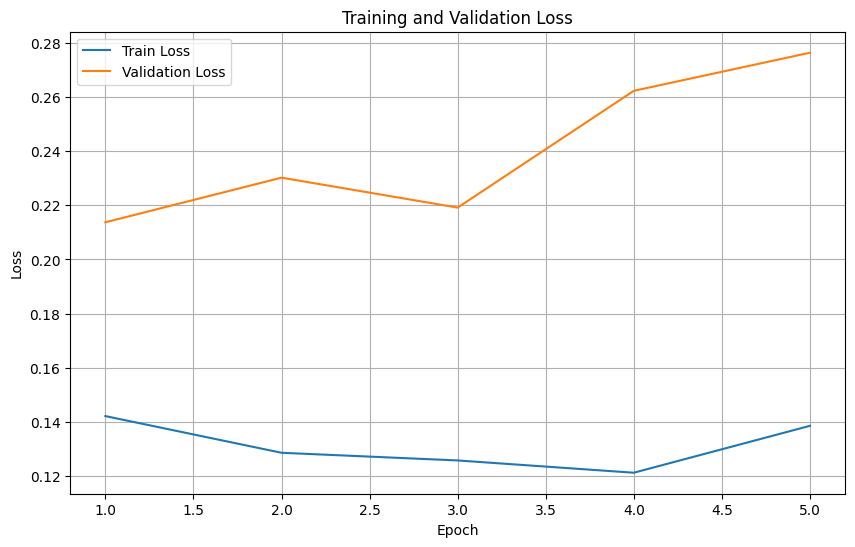

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

### Roberta + CossineEmbeding Loss

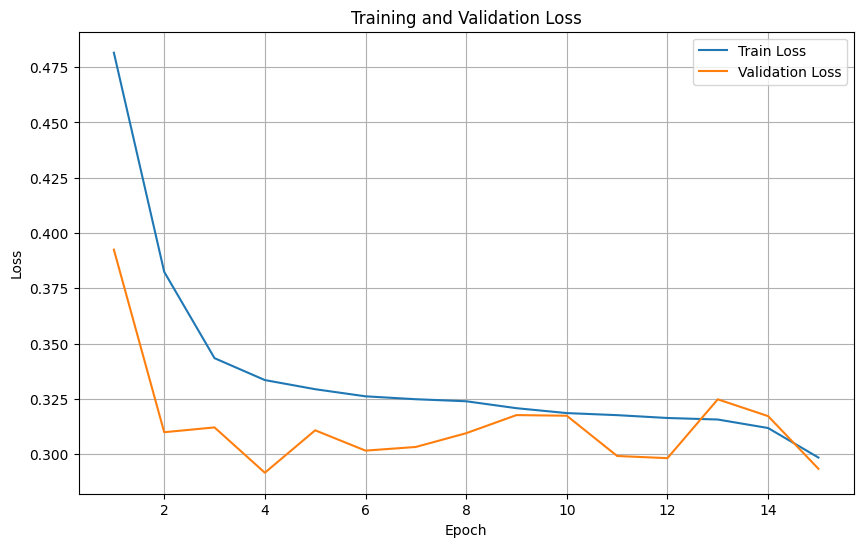

In [91]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), train_losses, label="Train Loss")
plt.plot(range(1, EPOCHS + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_load = SiameseRoBERTa()
model_load.load_state_dict(torch.load('siamese_roberta_model.pth', map_location=device))
model_load.to(device)
model_load.eval()

tokenizer = RobertaTokenizer.from_pretrained('roberta-base')


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-39-55a1de0c43be>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recomm

In [40]:
model_load.eval()
cosine_similarities = []
labels = []

with torch.no_grad():
    for batch in val_loader:
        resume_vecs, job_vecs = model_load(
            batch['resume_input_ids'].to(device),
            batch['resume_attention_mask'].to(device),
            batch['job_input_ids'].to(device),
            batch['job_attention_mask'].to(device)
        )

        sims = compute_cosine_similarity(resume_vecs, job_vecs).detach().cpu().numpy()
        cosine_similarities.extend(sims)
        labels.extend(batch['label'].numpy())

acc = compute_accuracy(np.array(cosine_similarities), np.array(labels))
print(f"Accuracy: {acc:.4f}")


Accuracy: 0.7044


In [42]:
from collections import defaultdict
import numpy as np
from sklearn.metrics import precision_score
import torch

def compute_precision_at_k(model, val_dataset, k=10, device='cpu'):
    model.eval()
    
    # Зберігатимемо всі векторні подання і мітки
    all_resume_vecs = []
    all_job_vecs = []
    all_labels = []
    all_job_texts = []
    all_resume_texts = []

    for i in range(len(val_dataset)):
        sample = val_dataset[i]

        resume_input_ids = sample['resume_input_ids'].unsqueeze(0).to(device)
        resume_attention_mask = sample['resume_attention_mask'].unsqueeze(0).to(device)
        job_input_ids = sample['job_input_ids'].unsqueeze(0).to(device)
        job_attention_mask = sample['job_attention_mask'].unsqueeze(0).to(device)

        with torch.no_grad():
            resume_vec, job_vec = model(resume_input_ids, resume_attention_mask,
                                        job_input_ids, job_attention_mask)

        all_resume_vecs.append(resume_vec.cpu())
        all_job_vecs.append(job_vec.cpu())
        all_labels.append(sample['label'].item())

        all_job_texts.append(val_dataset.df.iloc[i]['job_description_text_clean'])
        all_resume_texts.append(val_dataset.df.iloc[i]['resume_text_clean'])

    resume_vecs = torch.cat(all_resume_vecs)
    job_vecs = torch.cat(all_job_vecs)
    labels = np.array(all_labels)

    # групуємо по job_text: для кожної вакансії — обираємо топ-10 резюме
    job_to_indices = defaultdict(list)
    for idx, job_text in enumerate(all_job_texts):
        job_to_indices[job_text].append(idx)

    precisions = []

    for job_text, indices in job_to_indices.items():
        if len(indices) < k:
            continue  # пропустити, якщо менше ніж k пар

        # Витягуємо вектори для цієї вакансії
        job_vector = job_vecs[indices[0]]  # всі мають однаковий job_vec для цього job_text
        resumes = resume_vecs[indices]
        sims = torch.nn.functional.cosine_similarity(resumes, job_vector.unsqueeze(0))

        # Отримуємо індекси топ-K схожих резюме
        topk_idx = sims.topk(k=k).indices
        topk_labels = labels[np.array(indices)[topk_idx]]

        # precision@k — скільки з топ-k мають label == 1
        precision_at_k = np.mean(topk_labels == 1)
        precisions.append(precision_at_k)

    return np.mean(precisions)


In [43]:
p_at_10 = compute_precision_at_k(model_load, val_dataset, k=10, device=device)
print(f"Precision@10: {p_at_10:.4f}")


Precision@10: 0.7326


In [38]:
resume_text = "Resume: Senior Backend Developer with 8 years of experience in Python, Django, PostgreSQL, AWS, microservices architecture, CI/CD, and REST APIs. Job Posting: Junior Frontend Developer (React) for students or recent graduates with skills in HTML, CSS, React, and Figma. There is a mismatch in technologies, experience level, focus area (backend vs frontend), and the candidate is overqualified for the position."

job_text =  "gfgjhj hjkhjhk"

In [39]:
resume_inputs = tokenizer(resume_text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
job_inputs = tokenizer(job_text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)

In [40]:
with torch.no_grad():
    resume_vec, job_vec = model(
        resume_inputs['input_ids'].to(device),
        resume_inputs['attention_mask'].to(device),
        job_inputs['input_ids'].to(device),
        job_inputs['attention_mask'].to(device)
    )



TypeError: SiameseRoBERTa.forward() missing 2 required positional arguments: 'neg_input_ids' and 'neg_attention_mask'

In [31]:
import torch.nn.functional as F
similarity = F.cosine_similarity(resume_vec, job_vec)
print(f"Cosine Similarity: {similarity.item():.4f}")

Cosine Similarity: 0.7635


In [195]:
!pip install hydra-core

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 4.9 MB/s eta 0:00:00


In [197]:
!pip install bitarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.3/299.3 kB 9.9 MB/s eta 0:00:00


In [199]:
import torch
roberta = torch.hub.load('pytorch/fairseq', 'roberta.large')
roberta.eval()

Using cache found in /root/.cache/torch/hub/pytorch_fairseq_main


TypeError: cannot unpack non-iterable NoneType object

## Keras

In [153]:
import tensorflow_hub as hub
# define a text embedding model
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)
preprocessor = hub.KerasLayer("https://kaggle.com/models/kaggle/roberta/TensorFlow2/en-cased-preprocess/1")
encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer("https://www.kaggle.com/models/kaggle/roberta/TensorFlow2/en-cased-l-12-h-768-a-12/1", trainable=True)
encoder_outputs = encoder(encoder_inputs)
pooled_output = encoder_outputs["pooled_output"]   
sequence_output = encoder_outputs["sequence_output"] 

model_test = tf.keras.Model(text_input, pooled_output)


ValueError: Exception encountered when calling layer 'keras_layer_1' (type KerasLayer).

A KerasTensor is symbolic: it's a placeholder for a shape an a dtype. It doesn't have any actual numerical value. You cannot convert it to a NumPy array.

Call arguments received by layer 'keras_layer_1' (type KerasLayer):
  • inputs=<KerasTensor shape=(None,), dtype=string, sparse=False, name=keras_tensor_1>
  • training=None